In [ ]:
# !pip install pydicom

# Imports

In [ ]:
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import pytorch_tools as pt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact

# from multiprocessing import Pool
# from sklearn.model_selection import train_test_split

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
%load_ext watermark
%watermark -v -n -m -p numpy,torch,pandas

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

Wed May 06 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.18.1
torch 1.3.1
pandas 1.0.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-96-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


# Data visualiziation

In [3]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


In [4]:
train_dcms = sorted(glob.glob('data/raw/siim/dicom-images-train/*/*/*.dcm'))
test_dcms = sorted(glob.glob('data/raw/siim/dicom-images-test/*/*/*.dcm'))
df = pd.read_csv("data/raw/siim/train-rle.csv", index_col=None)
# Fix incorrect name of CSV file
df.rename(columns={' EncodedPixels' : 'EncodedPixels'}, inplace=True)
print(f"Train images: {len(train_dcms)}, test images: {len(test_dcms)}, lines in DF: {len(df)}")
df.head()

# rles = np.genfromtxt("data/raw/siim/train-rle.csv", delimiter=',', dtype=str)

Train images: 12089, test images: 3205, lines in DF: 12954


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [8]:
from pytorch_tools.utils.rle import rle_decode
# Show images + their masks
@interact(idx=(0,20), )
def f(idx=14, show_mask=False, use_clahe=True, dilate_mask=False):
    dataset = pydicom.dcmread(train_dcms[idx])
    #show_dcm_info(dataset)
    plt.figure(figsize=(5,5))
    
    pixels = dataset.pixel_array
    print(pixels.shape)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        pixels = clahe.apply(pixels)
    plt.imshow(pixels, cmap=plt.cm.bone)
    
    img_id = train_dcms[idx].split('/')[-1][:-4]
    print(img_id)
    rle_mask = df[df['ImageId'] == img_id]["EncodedPixels"].values

    if show_mask and (rle_mask[0] != '-1'):
        plt.title('Mask')
        print(f"Num masks: {len(rle_mask)}")
        for rle in rle_mask:
            mask = rle_decode(rle, pixels.shape, relative=True).astype(np.uint8)
            if dilate_mask:
                mask_sz = np.sqrt(np.sum(mask))
                k_sz = int(mask_sz * 0.1)
                kernel = np.ones((k_sz, k_sz))
                mask = cv2.dilate(mask, kernel, iterations = 1)
#             pixels[mask == 1] = 255
            plt.imshow(mask, alpha=0.6)
    else:
        plt.title('No mask')
    plt.show()

interactive(children=(IntSlider(value=14, description='idx', max=20), Checkbox(value=False, description='show_…

In [9]:
def apply_thresholds(
    mask,
    min_total_area=2048,
    min_component_area=512,
    top_threshold=0.5, 
    bottom_threshold=0.5):
    """Convert probabilities into binary mask.
    1. Filter by top threshold 
    2. If remaining image is bigger than min_total_area
    3. Apply bottom_threshold
    4. Filter by min_component_area.
    Args:
        mask (np.array): Scores. Shape = (1024, 1024)
        min_total_area (int): Minimal area of a mask
        min_component_area (int): Minimal area of COMPONENT
        top_threshold (float): Used to remove noise
        bottom_threshold (float): Actual threshold
    """
    # Sanity checks
    assert type(mask) == np.ndarray
    assert mask.shape == (1024, 1024)
    assert (0.0 <= mask.min()) & (mask.max() <= 1.0)
    
    empty_mask = np.zeros(mask.shape, dtype=np.uint8)
    
    top_binarized = (mask >= top_threshold).astype(np.uint8)
    if top_binarized.sum() < min_total_area:
        return empty_mask
    
    bottom_binarized = (mask >= bottom_threshold).astype(np.uint8)
    # Find all connected components
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(bottom_binarized, connectivity=8)
    # Remove background
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    
    binary_mask = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_component_area
    for i in range(nb_components):
        if sizes[i] >= min_component_area:
            binary_mask[output == i + 1] = 255
    return binary_mask


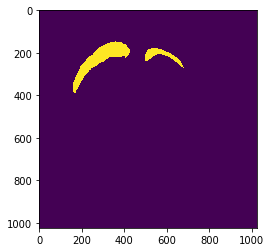

In [26]:
# Read mask for an image with pneumothorax
image_id = '1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942'
mask = cv2.imread(f'data/interim/masks/{image_id}.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
pred_mask = ((mask / 255.0) * 0.6)
binary_mask = apply_thresholds(pred_mask, top_threshold=0.5, min_component_area=2000)
plt.imshow(binary_mask)

In [ ]:
# fold = 0
# df = pd.read_csv("data/interim/train_val.csv")
# df = df[(df["Fold"] == fold)]
# print(len(df))
# classes = list(df["Class"])
# df.groupby("Class").count()
# list(df[:1].Index)

In [ ]:
# test_images = os.listdir("data/interim/images")

In [ ]:
# image = cv2.imread('data/interim/masks/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png', cv2.IMREAD_GRAYSCALE)
# print(image.shape)
# plt.imshow(image)

# image3 = np.stack([image, image, image], axis=2)
# print(image3.shape)
# plt.imshow(image3)

In [ ]:
# There is more than 1 mask for some images. Let's plot them
# 
# df_duplicates = df[df.duplicated(subset="ImageId", keep=False)]
# # df_duplicates[df_duplicates.ImageId == "1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487"]
# df_duplicates


In [ ]:
## 1. Read all masks from data/interim/masks
## 2. Skip if empty
## 3. Count number of components on mask
## 4. Count total area and individual area of each component
## 5. Plot histograms of areas for all non-empty masks
# masks_files = os.listdir("data/interim/masks")
# total_areas = []
# individual_areas = []
# for mask_file in tqdm(masks_files):
# #     print('data/interim/masks/' + mask_file)
#     mask = cv2.imread('data/interim/masks/' + mask_file, cv2.IMREAD_GRAYSCALE)
#     total_areas.append(np.sum(mask, dtype=np.uint32))
    


In [ ]:
# plt.hist(total_areas, range=(1, 1024*1024))

In [ ]:
# reshaped_mask = cv2.resize(
#     choosen,
#     dsize=(1024, 1024),
#     interpolation=cv2.INTER_LINEAR
# )
    
def apply_thresholds(
    mask,
    min_total_area=2048,
    min_component_area=512,
    top_threshold=0.5, 
    bottom_threshold=0.5):
    """Convert probabilities into binary mask.
    1. Filter by top threshold 
    2. If remaining image is bigger than min_total_area
    3. Apply bottom_threshold
    4. Filter by min_component_area.
    Args:
        mask (np.array): Scores. Shape = (1024, 1024)
        min_total_area (int): Minimal area of a mask
        min_component_area (int): Minimal area of COMPONENT
        top_threshold (float): Used to remove noise
        bottom_threshold (float): Actual threshold
    """
    # Sanity checks
    assert type(mask) == np.ndarray
    assert mask.shape == (1024, 1024)
    assert (0.0 <= mask.min()) & (mask.max() <= 1.0)
    
    empty_mask = np.zeros(mask.shape, dtype=np.uint8)
    
    top_binarized = (mask >= top_threshold).astype(np.uint8)
    if top_binarized.sum() < min_total_area:
        return empty_mask
    
    bottom_binarized = (mask >= bottom_threshold).astype(np.uint8)
    # Find all connected components
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(bottom_binarized, connectivity=8)
    # Remove background
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    
    binary_mask = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_component_area
    for i in range(nb_components):
        if sizes[i] >= min_component_area:
            binary_mask[output == i + 1] = 255
    return binary_mask


In [ ]:
num_masks = []
cnt = 0
for train_dcm in train_dcms:
    img_id = train_dcm.split('/')[-1][:-4]
    rle_masks = df[df['ImageId'] == img_id]["EncodedPixels"].values
    try:
        if rle_masks[0] == '-1':
            num_masks.append(0)
        else:
            num_masks.append(len(rle_masks))
    except IndexError:
#         print(f"Idx: {img_id} not found!")
        cnt += 1
print(f"Succes! Not found {cnt} images")

In [ ]:
from pytorch_tools.utils.rle import rle_to_string, rle_encode, rle_decode

In [ ]:
# we have more rles than images. need to merge them
# new_rles = []
# for un_idx in tqdm_notebook(np.unique(rles[:, 0])):
#     idx_rles = rles[rles[:,0] == un_idx][:, 1]
#     masks = [rle_decode(rle, (1024,1024), relative=True) for rle in idx_rles]
#     mask = np.clip(np.sum(masks, axis=0), 0,1)
#     new_rle = rle_to_string(rle_encode(mask))
#     new_rle = new_rle if new_rle else '-1'
#     new_rles.append(new_rle)

In [ ]:
# with open('input/train-rle-filtered.csv', 'w') as f:
#     lines = [','.join([idx, rle]) for idx, rle in zip(np.unique(rles[:, 0]), new_rles)]
#     result = '\n'.join(lines)
#     f.write(result)


In [ ]:
# #np.random.shuffle(train_dcms)
# @interact(n=(0,20))
# def f(n=4, show_mask=True, use_clahe=False, dilate_mask=False):
#     dataset = pydicom.dcmread(train_dcms[n])
#     #show_dcm_info(dataset)
#     plt.figure(figsize=(5,5))
#     pixels = dataset.pixel_array
    
#     if use_clahe:
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         pixels = clahe.apply(pixels)

#     plt.imshow(pixels, cmap=plt.cm.bone)
    
#     img_id = train_dcms[idx].split('/')[-1][:-4]
#     try:
#         rle_mask = rles[rles[:,0] == img_id][0, 1]
#     except:
#         rle_mask = '-1'
#     if rle_mask != '-1':
#         plt.title('See Marker')
#         mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
#         if show_mask:
#             if dilate_mask:
#                 mask_sz = np.sqrt(np.sum(mask))
#                 k_sz = int(mask_sz * 0.1)
#                 kernel = np.ones((k_sz, k_sz))
#                 mask = cv2.dilate(mask,kernel,iterations = 1)
#             pixels[mask == 1] = 255
#             plt.imshow(pixels, cmap=plt.cm.bone)
#     else:
#         plt.title('Nothing to see')
#     plt.show()

## Show masks histograms

In [ ]:
def get_mask_size(rles):
    sizes = []
    for rle in rles:
        if rle == '-1':
            sizes.append(0)
            continue
        sizes.append(sum([int(ii) for ii in rle.split()[1::2]]))
    return sizes

In [ ]:
with_mask = rles[rles[:,1] != '-1']
print('Total images: {}. Has masks: {}'.format(len(rles), len(with_mask)))
mask_sizes = get_mask_size(rles[:, 1])
mask_sizes = [i / (1024*1024)*100 for i in mask_sizes if i > 0]
print('Max mask/image perc: {}. Min: {}. Mean: {}.'.format(max(mask_sizes),min(mask_sizes), np.mean(mask_sizes)))
plt.hist(mask_sizes, bins=50);

## Train test val split

In [ ]:
train, val_test = train_test_split(rles, stratify=rles[:,1] != '-1', test_size=0.2, random_state=42)
val, test = train_test_split(val_test, stratify=val_test[:,1] != '-1', test_size=0.5, random_state=42)
train_idx = set(train[:,0])
val_idx = set(val[:,0])
test_idx = set(test[:,0])
np.save('workdir/train_idx', train[:,0])
np.save('workdir/test_idx', test[:,0])
np.save('workdir/val_idx', val[:,0])

# Preprocess datasets

In [ ]:
# save train images
os.makedirs('workdir/preprocessed_train/images/', exist_ok=True)
os.makedirs('workdir/preprocessed_train/masks/', exist_ok=True)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
USE_CLAHE = False
DILATE_MASK = False
def save_one(pair):
    idx, dcm = pair
    #filename = '{:06d}.'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    img_id = dcm.split('/')[-1][:-4]
    try:
        rle_mask = rles[rles[:,0] == img_id][0, 1]
    except:
        rle_mask = '-1'
    if rle_mask == '-1':
        mask = np.zeros((1024,1024),dtype=np.uint8)
    else:
        #print(rle_mask)
        mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
    #print(np.mean(mask))
    # make images more contrast
    img = clahe.apply(img) if USE_CLAHE else img
    # make masks bigger for easier detection
    if DILATE_MASK:
        mask_sz = np.sqrt(np.sum(mask))
        k_sz = int(mask_sz * 0.05) # dilate by 5% of mask size
        kernel = np.ones((k_sz, k_sz))
        mask = cv2.dilate(mask,kernel,iterations = 1)
    cv2.imwrite('workdir/preprocessed_train/images/'+img_id + '.jpg', img)
    cv2.imwrite('workdir/preprocessed_train/masks/'+img_id + '.png', mask) #PNG for masks!

pairs = list(zip(list(range(len(train_dcms))), train_dcms))
with Pool() as pool:
    for _ in tqdm_notebook(pool.imap_unordered(save_one, pairs), total=len(pairs)):
        pass

In [ ]:
sizes = get_mask_size(rles[:, 1])
def f(x):
    if x == 0:
        return 0
    elif x < 1:
        return 1
    else:
        return 2
classes = [f(s) for s in sizes]

In [ ]:
# save test images
os.makedirs('workdir/test/images', exist_ok=True)
for idx, dcm in enumerate(tqdm_notebook(test_dcms)):
    filename = '{:06d}.png'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    cv2.imwrite('workdir/test/images/'+filename, img)